# Transforms on Data Part II

Here we continue looking at transforming our data with a few *linear* transforms, i.e., transforms that can be represented by summation (or integration) and multiplication by constants.

Here we will see that the Fourier transform follows naturally from the concept of using a convolution to detect a signal in noise. In our last notebook, we saw that a convolution helped us to find where a pulse was located in a noisy signal.

We were able to use this trick because we had a template of the signal that we expected handy. But what if we didn't know what signal we were expecting? What if we had a tool to check for the presence of every possible sinusoid and let us know which ones might make up our signal?

The Fourier transform is here to help! We begin by generating some data that has multiple tones in it.


[Text(0.5, 0, 'Time (ms)'),
 Text(0, 0.5, 'Voltage (mV)'),
 Text(0.5, 1.0, 'Multiple Tones with -10 dB SNR')]

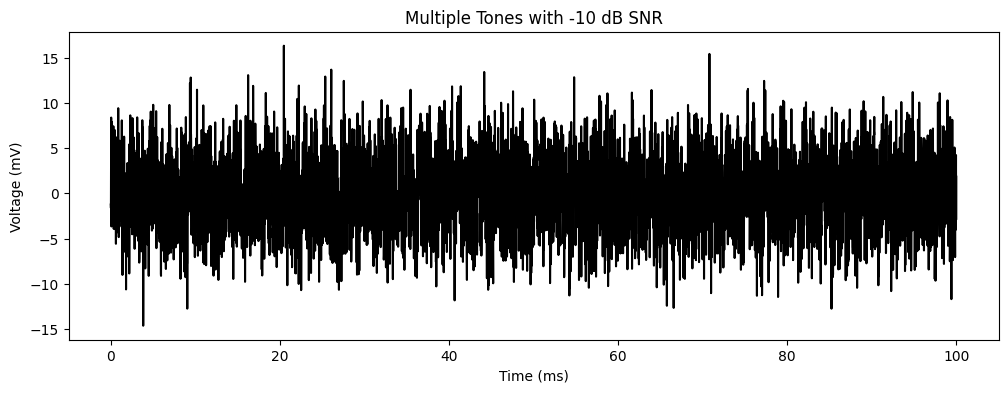

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from signal_tools import add_white_gaussian_noise, generate_tone_signal

# Setup
SEC_TO_MSEC = 1e3
rng_seed = 1000
rng = np.random.default_rng(rng_seed)
end_time_seconds = 0.1
pulse_start_seconds = 0.00
pulse_end_seconds = 0.1
frequency1_hz = 440
frequency2_hz = 880
frequency3_hz = 1320

# Generate a signal - sample well above Nyquist
sampling_frequency = frequency3_hz * 50
sampling_time_seconds = 1 / sampling_frequency
time_seconds = np.arange(0, end_time_seconds, sampling_time_seconds)

tone1_signal = generate_tone_signal(
    time_seconds, pulse_start_seconds, pulse_end_seconds, frequency1_hz
)

tone2_signal = generate_tone_signal(
    time_seconds, pulse_start_seconds, pulse_end_seconds, frequency2_hz
)

tone3_signal = generate_tone_signal(
    time_seconds, pulse_start_seconds, pulse_end_seconds, frequency3_hz
)

combined_signal = tone1_signal + tone2_signal + tone3_signal

# Add noise
snr_db = -10
noisy_signal = add_white_gaussian_noise(combined_signal, snr_db, rng)

# Plot the result
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(time_seconds * SEC_TO_MSEC, noisy_signal, color="k")
ax.set(
    xlabel="Time (ms)",
    ylabel="Voltage (mV)",
    title=f"Multiple Tones with {snr_db} dB SNR",
)

## The Fourier Transform and the FFT

It is hard to tell what is going on from this plot alone. The information from all three of our signals overlaps in time, which makes it hard to even tell that there are three unique signals present. The noise makes the problem more challenging. Which fluctuations in the signal are due to random noise, and which are due to higher frequency signals? It is hard to tell.

This is where the Fourier transform can help. The Fourier transform is closely related to the correlation exercise that we just performed. The Fourier transform, in essence, tests a signal for the presence of a whole *spectrum* of sinusoids. It is analogous to a `for` loop. Each iteration of the loop uses the same multiplication technique we just learned about to check if a sinusoid at a specific frequency is present in the signal. Because this integrates information from the entire duration that the sinusoid is present, it also helps to pull the signals out of the noise. Sinusoids appear as peaks in the spectrum uncovered by the Fourier transform.

The Fourier transform is defined in continuous time by

$$
\mathcal{F}[f(t)] (\xi) = \int_{-\infty}^{\infty} f(t) e^{-i 2 \pi \xi t} dt.
$$

Notice the similarity to the convolution formula. The transform is summing over the product of the signal under inspection, $f(t)$ with a sinusoid of frequency $\xi$. If frequency $\xi$ is present, the summation (or integral in the continuous time case) over that product will be large and register a peak for that unique value of $\xi$.

If the sinusoid is hard to spot, remember Euler's formula

$$
e^{i t} = \cos(t) + i \sin(t) .
$$

Applying Euler's identity to the Fourier transform yields the sine and cosine transforms.

$$
\mathcal{F^{s}}[f(t)] (\xi) = \int_{-\infty}^{\infty} f(t) \sin^{2 \pi \xi t} dt, \\
\mathcal{F^{c}}[f(t)] (\xi) = \int_{-\infty}^{\infty} f(t) \cos^{2 \pi \xi t} dt.
$$

The Fourier transform is implemented in mathematical libraries as the Fast Fourier Transform (FFT) and the FFT is one of the most important algorithms of all time. Luckily, NumPy handles all of this for us!

In practice, the Fourier transform is usually applied to complex data instead of real data. In fact, it is so convenient to work with complex data when performing this type of data visualization and analysis that we have yet another transform that can help us convert real data into complex data, called the Hilbert transform. We might cover the Hilbert transform and more advanced Fourier analysis in this class as one of our special topics, depending on student interest.

There are subtleties to working with the Fourier transform on real and complex data that will we not cover immediately in this course. For now, we will apply the Fourier transform to real data only, and let NumPy handle those issues for us by specifying to Numpy that we are using real data.

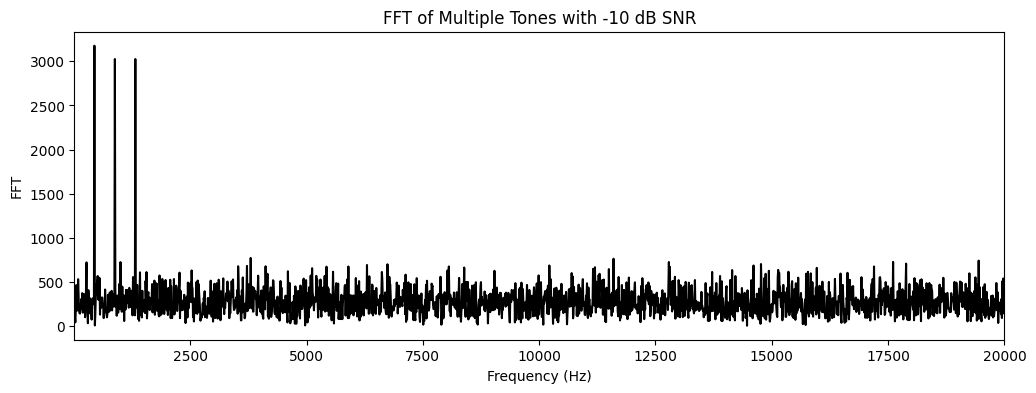

In [2]:
# Use rfft to specify to NumPy that we are working with real data
rfft_of_noisy_signal = np.fft.rfft(noisy_signal)

# Use rfftfreq to determine which frequency corresponds to which point in the
# FFT output
number_of_points = len(time_seconds)
frequencies = np.fft.rfftfreq(number_of_points, sampling_time_seconds)

# Plot the data - limit axes to the limits of human hearing
fig, ax = plt.subplots(figsize=(12, 4))
_ = ax.plot(frequencies, np.abs(rfft_of_noisy_signal), color="k")
_ = ax.set(
    xlabel="Frequency (Hz)",
    ylabel="FFT",
    title=f"FFT of Multiple Tones with {snr_db} dB SNR",
    xlim=(10, 20e3),
)